# Классификация изображений с использованием pytorch_lightning

Импортируем как обычно вспомогательные библиотеки:

In [63]:
%matplotlib inline
%load_ext tensorboard

import os
import random
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import pytorch_lightning as pl
import torch
import torchvision

print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 16

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.2.1
2.2.2
0.17.2


## Подготовка данных

Как и в скринкастах, возьмьем еще один пример датасета с Kaggle — [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition).

Задача состоит в том, чтобы определять тип цветка (один из 5) по фотографии (всего их в датасете чуть больше 4317).

In [59]:
!ls data/

train      validation


In [61]:
!find data/train -type f | wc -l

    4218


In [62]:
!find data/validation -type f | wc -l

     111


Создайте объекты датасетов для обучения и валидации (на которую оставьте 512 изображений):

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision.datasets import ImageFolder

dataset = ImageFolder('flowers')

sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, train_size=None, random_state=2021)

X = [x[0] for x in dataset.samples]
y = [x[1] for x in dataset.samples]

train_idx, valid_idx = list(sss.split(X, y))[0]


In [44]:
from copy import copy

train_dataset = copy(dataset)
train_dataset.samples = [dataset.samples[i] for i in train_idx]
train_dataset.targets = [dataset.targets[i] for i in train_idx]
train_dataset.imgs = train_dataset.samples

valid_dataset = copy(dataset)
valid_dataset.samples = [dataset.samples[i] for i in valid_idx]
valid_dataset.targets = [dataset.targets[i] for i in valid_idx]
valid_dataset.imgs = valid_dataset.samples


print(len(train_dataset), len(valid_dataset))

3317 1000


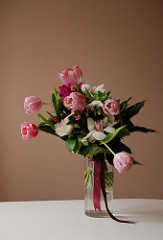

In [45]:
img, cls = random.choice(train_dataset)
img

Отобразить примеры из датасетов обучения и валидации:

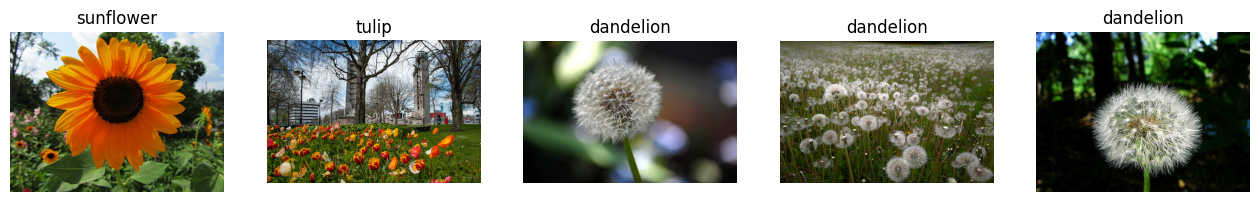

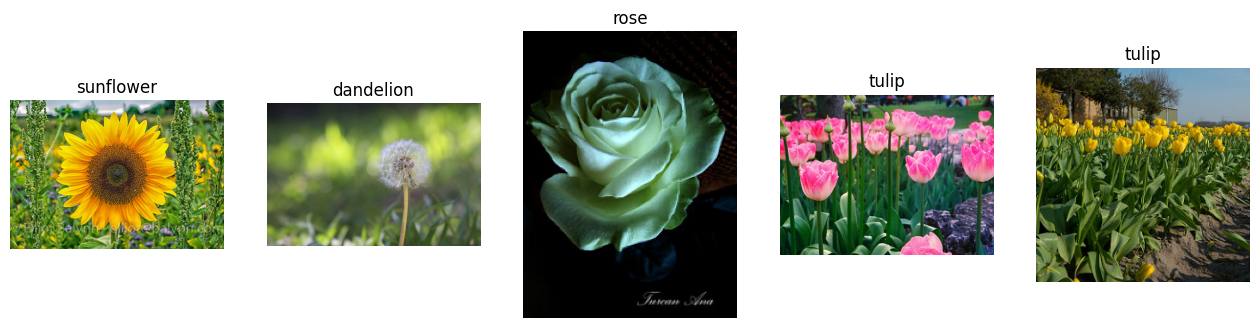

In [46]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)
plot_samples(valid_dataset)

Определяем даталоадеры для обучения и валидации:

In [64]:
from torchvision import transforms
from torch.utils.data import DataLoader

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

## Обучение модели

Для обучения модели с помощью pytorch-lighning необходимо определить обучающий модуль класса `LightningModule`.

Внутри он из себя представляет все тот же `nn.Module`, но с дополнительным багажом полезных возможностей.

Давайте определим такой модуль для нашей задачи, предполагая делать файн-тюнинг предобученной ResNet-34:

In [65]:
from torchvision import models
models.resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
from torch.nn import functional as F


class FlowersModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # используем предобученную модель ResNet-34
        self.net = models.resnet34(pretrained=True)
        # замораживаем веса
        for parameter in self.net.parameters():
            parameter.requres_grad = False
        # заменяем полносвязный слой на новый под количество классов из train_dataset
        self.net.fc = torch.nn.Linear(512, len(train_dataset.classes))

    # вызов модуля
    def forward(self, x):
        return self.net(x)

    # шаг обучения
    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self.net(images)
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        # нужно вернуть основное значение лосса (функции потерь)
        return loss

    def validation_step(self, batch, batch_idx):

        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        self.net.eval()

        images, target = batch
        output = self(images)

        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    # используемые оптимизаторы
    def configure_optimizers(self):
        return torch.optim.Adam(self.net.parameters(), lr=1e-2, weight_decay=1e-4)

In [66]:
flowers_model = FlowersModel()

И запустим процесс обучения с помощью "обучателя" `pl.Trainer`:

In [57]:
# Инициализируем модуль
flowers_model = FlowersModel()

# Инициализируем обучатель
trainer = pl.Trainer(
    # используем 1 видеокарту
    # gpus=1,
    # обучаем в течение 30-ти эпох
    max_epochs=3,
    # обновляем прогрессбар каждые 10 итераций
    # progress_bar_refresh_rate=10,
    accelerator="auto"
)

# Обучаем модель обучателем на нашем датасете
trainer.fit(flowers_model, train_loader, valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 21.3 M
--------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 208/208 [04:32<00:00,  0.76it/s, v_num=6, loss/val=1.280, top1/val=0.416, top1/train=0.421] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 208/208 [04:33<00:00,  0.76it/s, v_num=6, loss/val=1.280, top1/val=0.416, top1/train=0.421]


In [53]:
help(trainer)

Help on Trainer in module pytorch_lightning.trainer.trainer object:

class Trainer(builtins.object)
 |  Trainer(*, accelerator: Union[str, pytorch_lightning.accelerators.accelerator.Accelerator] = 'auto', strategy: Union[str, pytorch_lightning.strategies.strategy.Strategy] = 'auto', devices: Union[List[int], str, int] = 'auto', num_nodes: int = 1, precision: Union[Literal[64, 32, 16], Literal['transformer-engine', 'transformer-engine-float16', '16-true', '16-mixed', 'bf16-true', 'bf16-mixed', '32-true', '64-true'], Literal['64', '32', '16', 'bf16'], NoneType] = None, logger: Union[pytorch_lightning.loggers.logger.Logger, Iterable[pytorch_lightning.loggers.logger.Logger], bool, NoneType] = None, callbacks: Union[List[pytorch_lightning.callbacks.callback.Callback], pytorch_lightning.callbacks.callback.Callback, NoneType] = None, fast_dev_run: Union[int, bool] = False, max_epochs: Optional[int] = None, min_epochs: Optional[int] = None, max_steps: int = -1, min_steps: Optional[int] = None,

## Анализ обученной модели

По умолчанию наш трейнер записывает логи обучения в формате TensorBoard в директории `lightning_logs/`.

Давайте запустим расширение `tensorboard` для ноутбука, чтобы отобразить его прямо здесь:

(скриншот того, что здесь ожидается увидеть, приведен ниже)

In [56]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6007 (pid 86817), started 0:02:31 ago. (Use '!kill 86817' to kill it.)

![tensorboard](./tensorboard.png)

Видим, что и на обучении и на валидации было достигнуто качество в районе 95%!

## Предсказание построенной моделью

Загрузим фото розы из интернета:

In [67]:
from PIL import Image

image = Image.open("rose.jpg")

flowers_model(torch.random(1,3,224,224))

TypeError: 'module' object is not callable

In [ ]:
";".join(list(map(str,[1,0])))

'1;0'

Сделайте предсказание для нашего изображение с помощью обученной модели:

In [ ]:
help(trainer.model)

# predicted = 1

Help on FlowersModel in module __main__ object:

class FlowersModel(pytorch_lightning.core.module.LightningModule)
 |  Method resolution order:
 |      FlowersModel
 |      pytorch_lightning.core.module.LightningModule
 |      lightning_fabric.utilities.device_dtype_mixin._DeviceDtypeModuleMixin
 |      pytorch_lightning.core.mixins.hparams_mixin.HyperparametersMixin
 |      pytorch_lightning.core.hooks.ModelHooks
 |      pytorch_lightning.core.hooks.DataHooks
 |      pytorch_lightning.core.hooks.CheckpointHooks
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  configure_optimizers(self)
 |      Choose what optimizers and learning-rate schedulers to use in your optimization. Normally you'd need one.
 |      But in the case of GANs or similar you might have multiple. Optimization with multiple optimizers only works in
 |      the manual opti

Какому классу соответствует предсказание?

In [ ]:
...

'rose'